# In Depth: k-Means Clustering
Clustering algorithms are another type of unsupervised machine learning models. Clustering algorithms seek to learn, from the properties of the data, an optimal division or discrete labeling of groups of points.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

# Introducing k-Means
The k-means algorithm searches for a predetermined number of clusters within an unlabeled multidimensional dataset. It accomplishes this using a simple conception of what the optimal clustering looks like:
 - The "cluster center" is the arithmetic mean of all the points belonging to the cluster.
 - Each point is closer to its own cluster center than to other cluster centers.
 
Those two assumptions are the basis of the k-means model. Let's take a look at a simple dataset to see k-means in action.

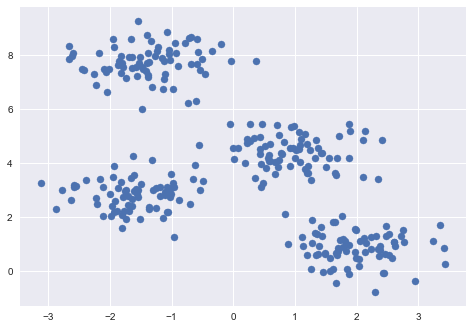

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4, cluster_std=0.6, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

In [3]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

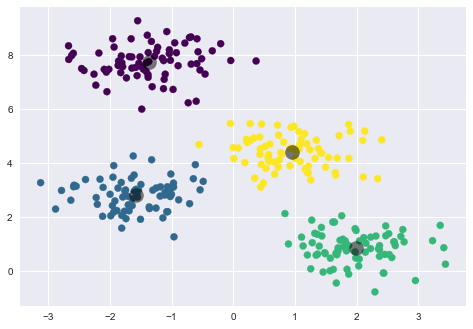

In [4]:
# visualize results
plt.scatter(X[:,0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

The k-means algorithm assigns the points to clusters very similarly to how we might assign them by eye. How is this algorithm able to find the clusters so quickly? The number of possible combinations of cluster assignments is exponential - an exhaustive search would be very costly. K-means actually doesn't require an exhaustive search; it uses an intuitive iterative approach called ***expectation-maximization***.

## k-Means Algorithm: Expectation-Maximization
Expectation-maximization (E-M) is a powerful algorithm that comes in a variety of contexts within data science. The expectation-maximization approach consists of the following steps:
 1. Guess some cluster centers
 2. Repeat until converged
     a. Expectation Step: assign points to the nearest cluster center
     b. Maximization Step: set the cluster centers to the mean
     
The expectation step involves updating our expectation of which cluster each point belongs to. The maximization step involves maximizing some fitness function that defines the location of the cluster centers. Under typical circumstances, each repetition of the E-step and M-step will alwasy result in a better estimate of the cluster characteristics.

![exp-max](images/expectationmaximization.png)

In the image above, the clusters converge in three iterations.

In [5]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels==i].mean(0) for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
        
    return centers, labels

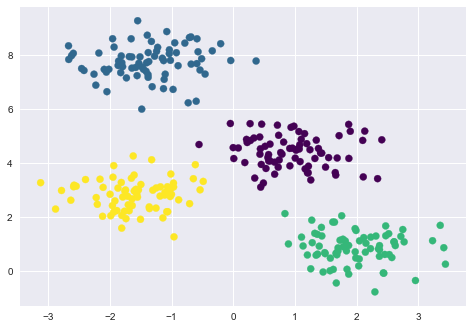

In [6]:
centers, labels = find_clusters(X, 4)
plt.scatter(X[:,0], X[:,1], c=labels, s=50, cmap='viridis');

#### Caveats of expectation-maximization
There are a few issues when using expectation-maximization:
 - **The globally optimal result may not be acheived**
     - Although the E-M procedure is guaranteed to improve the result in each step, there is no assurance that it will lead to the global best solution. For example, if we use a different random seed in our procedure, the starting guesses will lead to poor results:

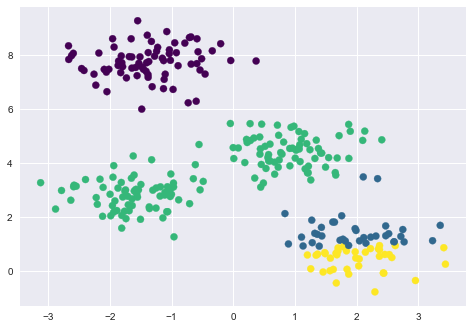

In [7]:
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:,0], X[:,1], c=labels, s=50, cmap='viridis');

 - Here the E-M approach has converged, but not to a globally optimal configuration. For this reason, it is common for the algorithm to be run for multiple starting guesses.
 
 
 - **The number of clusters must be selected beforehand**
     - Another common challenge is telling k-means how many clusters to expect: it cannot learn the number of clusters from the data. 

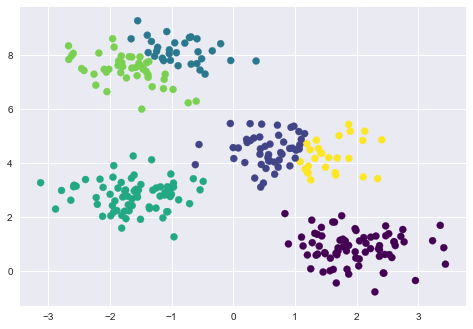

In [8]:
# tell k-means to find 6 clusters
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:,0], X[:,1], c=labels, s=50, cmap='viridis');

 - **k-means is limited to linear cluster boundaries**
     - The fundamental model assumptions of k-means (points will be closer to their own cluster center than to others) means that the algorithm will often be ineffective if the clusters have complicated geometries. The boundaries for k-means clusters will always be linear, so it will fail for more complicated boundaries.

In [11]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=0.5, random_state=0)

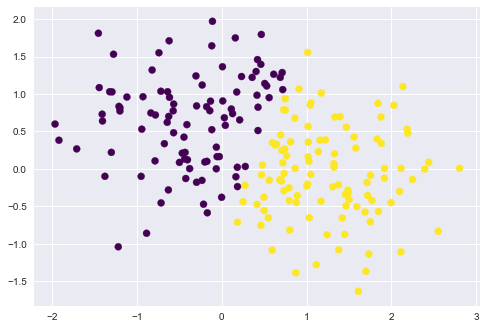

In [12]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:,0], X[:,1], c=labels, s=50, cmap='viridis');

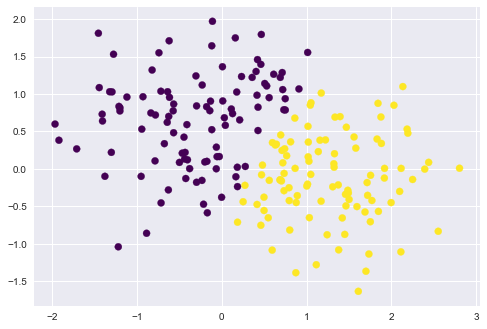

In [14]:
# try Kernelized k-Means
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:,0], X[:,1], c=labels, s=50, cmap='viridis');

 - **k-Means can be slow for large numbers of samples**
     - Because each iteration of k-means must access every point in the dataset, the algorithm can be relatively slow as the number of samples grows. One solution to this issue would be using batch-based k-means algorithms.
     
## Examples
#### Example 1: k-Means on digits
Here we will attempt to use k-means to try to identify similar digits without using the original label information. This is a common first step when trying to extract information from a new dataset where you don't have any label information.

In [15]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [16]:
kmeans = KMeans(n_clusters = 10, random_state = 0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

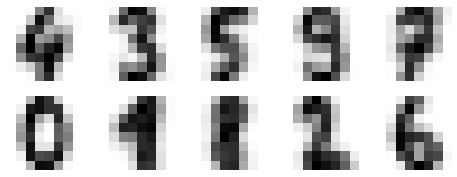

In [17]:
# let's view cluster centers
fig, ax = plt.subplots(2, 5, figsize=(8,3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

Cool! We see that even without labels, KMeans is able to find clusters whose centers are recognizable digits.

Because k-means knows nothing about the identity of the cluster, the 0-9 labels may be permuted. We can fix this by matching each learned cluster label with the true labels so we can check the model's accuracy.

In [18]:
from scipy.stats import mode
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(digits.target, labels)

0.79354479688369506

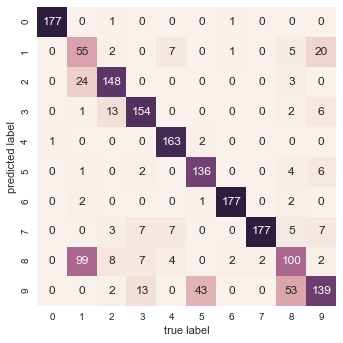

In [21]:
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels = digits.target_names,
            yticklabels = digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

With just a simple k-means algorithm, we were able to acheive 80% accuracy! Observing the confusion matrix, we see the largest source of confusion is between 1s and 8s, but this still shows that using k-means, we can essentially build a digit classifier without reference to any known labels!

Now let's use the t-distributed stochastic neighbor embedding (t-SNE) algorithm to preprocess the data before performing k-means. t-SNE is a nonlinear embedding algorithm that is particularly good at preserving points within clusters.

In [37]:
from sklearn.manifold import TSNE

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

In [38]:
# Compute the clusters
kmeans = KMeans(n_clusters = 10, random_state = 0)
clusters = kmeans.fit_predict(digits_proj)

In [39]:
# Permute the labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

In [40]:
# Compute the accuracy
accuracy_score(digits.target, labels)

0.91930996104618812

92% accuracy without using the labels! This is the power of unsupervised learning when used carefully: it can extract information from the dataset that might be difficult to do by hand or by eye.

#### Example 2: k-means for color compression
One interesting application of clustering is in color compression within images. Imagine you have an image with millions of colors. In most images, a large number of the colors with be unused, and many pixels in the image will have similar or identical colors. Consider the following:

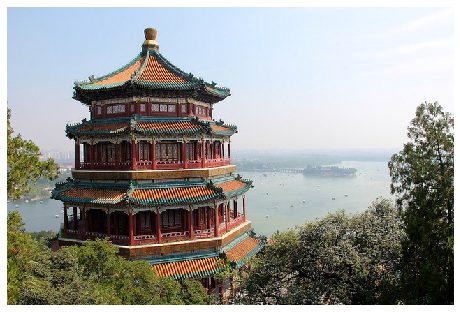

In [41]:
# Note: requires the pillow package
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

In [42]:
china.shape

(427, 640, 3)

The image itself is stored in a three-dimensional array of size (height, width, RGB), containing red/blue/green contributions as integers from 0 to 255.

One way to view this set of pixels is as a cloud of points in a three-dimensional color space. We will reshape the data to `n_samples x n_features`, and rescale the colors so they lie between 0 and 1.

In [43]:
data = china / 255.0 # 0->1 scale
data = data.reshape(427 * 640, 3) # bring it into 2 dimensions
data.shape

(273280, 3)

In [46]:
# visualize pixels in color space, using subset of 10K pixels
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
        
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0,1), ylim=(0,1))
    
    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0,1), ylim=(0,1))
    
    fig.suptitle(title, size=20)

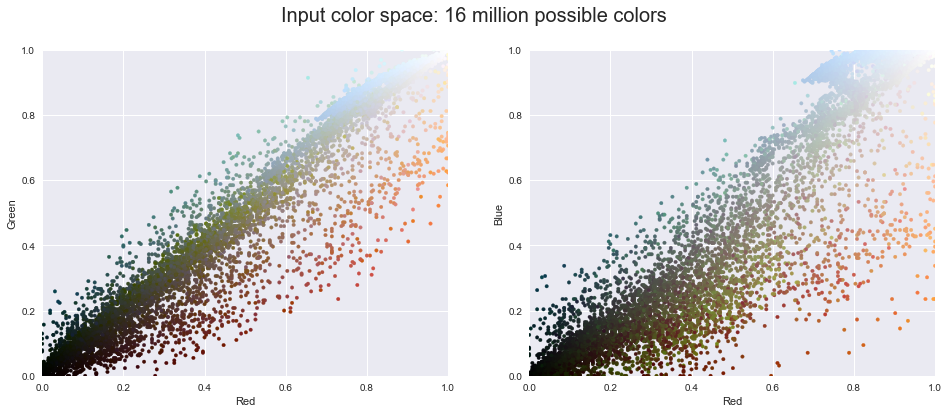

In [47]:
plot_pixels(data, title='Input color space: 16 million possible colors')

Now we will reduce the 16 million colors to just 16 colors using k-means clustering across the pixel space. Because we are dealing with a large dataset, we will use the mini batch k-means, whcih operates on subsets of the data to compute the result much more quickly than the standard k-means algorithm.

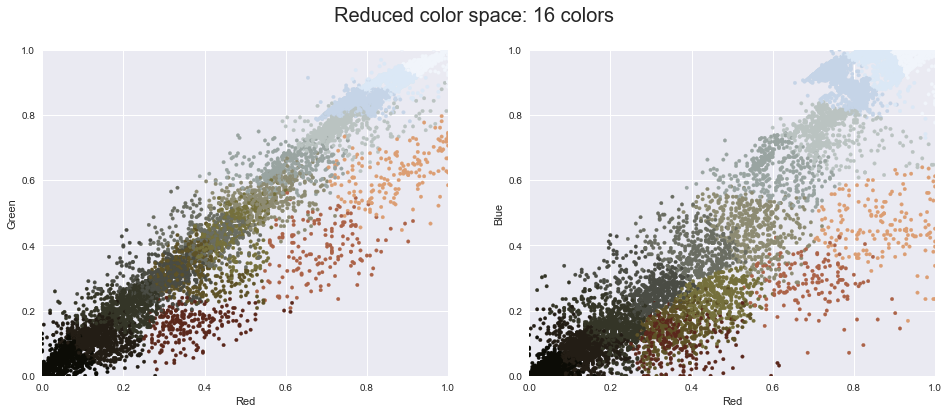

In [48]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors, title="Reduced color space: 16 colors")

The result is a recoloring of the original pixels, where each pixel is assigned the color of its closest cluster center. Let's plot the new colors in the image to better visualize this effect:

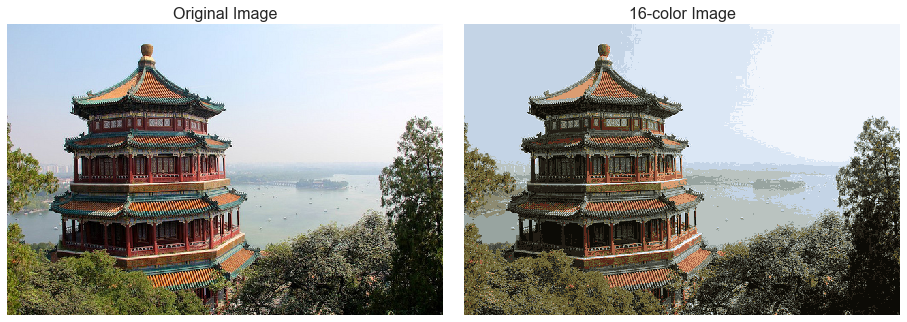

In [49]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16,6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);

Some of the detail is lost in the recolored image, but the image is still very recognizable. The image on the right achieves a compression factor of around 1 million! There are certainly better ways to compress information in images, but this example shows the power of thinking outside the box with unsupervised methods like k-means.